In [1]:
import numpy as np
import igl
import meshplot as mp
from scipy.spatial.transform import Rotation
import ipywidgets as iw
import time
import scipy.sparse as sp
import triangle as tr

In [2]:
v, f = igl.read_triangle_mesh('data/woody-hi.off')
cage = np.load('data/woody-hi.cage.npy')
v -= v.min(axis=0)
v /= v.max()

In [3]:
p = mp.plot(v, f, shading={"wireframe":True})
p.add_points(cage, shading={"point_color":"green", "point_size":0.1})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4306930…

1

In [4]:
p.add_lines(cage, np.vstack((cage[1:],cage[0])))

2

In [5]:
num_cage_boundary_v = cage.shape[0]

In [6]:
cage_connect = (np.vstack((np.arange(cage.shape[0]), np.arange(cage.shape[0])+1))).T
cage_connect[-1,-1] = 0

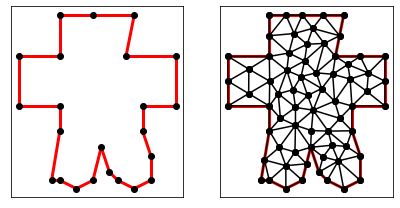

In [7]:
cage_dict = dict(vertices=cage[:,:2], segments=cage_connect)
cage_tri = tr.triangulate(cage_dict, 'pqa0.01')

import matplotlib.pyplot as plt

tr.compare(plt, cage_dict, cage_tri)
plt.show()

In [8]:
cage_v = cage_tri['vertices']
cage_f = cage_tri['triangles']

In [9]:
cage_oid = p.add_mesh(cage_v, cage_f, shading={"wireframe":True})

In [10]:
Lw = igl.cotmatrix(cage_v, cage_f)
M = igl.massmatrix(cage_v, cage_f, igl.MASSMATRIX_TYPE_VORONOI)
Minv = sp.diags(1 / M.diagonal())

In [11]:
selected_cage_v = np.array([0])

In [12]:
A = Lw * Minv * Lw
Aff = A[num_cage_boundary_v:,:]
Aff = Aff[:,num_cage_boundary_v:]
Afc = A[num_cage_boundary_v:,:]
Afc = Afc[:,:num_cage_boundary_v]
xc = np.zeros(num_cage_boundary_v)
xc[selected_cage_v] = 1
rhs = -Afc * xc
xf = sp.linalg.spsolve(Aff, rhs)
x = np.hstack((xc, xf))

In [13]:
# p.update_object(oid=cage_oid, colors=(x - x.min()) / x.max())
p.update_object(oid=cage_oid, colors=x)